## 1. Error Detection & Correction: Parity Bits

Parity bits are a simple error-detection mechanism. For even parity, the parity bit is set so that the total number of 1s in the message (including the parity bit) is even. The code below computes an even parity bit for an 8-bit data array.

In [1]:
# Function to compute even parity bit
def compute_even_parity(data):
    # Sum the data bits and take modulo 2.
    # If sum is odd, parity bit is 1 (to make total even); if even, parity bit is 0.
    return sum(data) % 2

# Original data bits (example)
data = [1, 0, 1, 0, 1, 1, 0, 0]
parity_bit = compute_even_parity(data)
print("Original Data:", data)
print("Computed Parity Bit (Even):", parity_bit)

# Transmitted data: append parity bit to the data array
transmitted_data = data + [parity_bit]
print("\nTransmitted Data (Data + Parity):", transmitted_data)

Original Data: [1, 0, 1, 0, 1, 1, 0, 0]
Computed Parity Bit (Even): 0

Transmitted Data (Data + Parity): [1, 0, 1, 0, 1, 1, 0, 0, 0]


### Exercise 1

Experiment with different data arrays and verify that the parity check computes the correct parity bit.

In [2]:
# Exercise 2: Simulate an error by flipping a bit in the transmitted data
error_index = 3  # For example, flip the bit at index 3 (0-indexed)
data_with_error = transmitted_data.copy()
data_with_error[error_index] = 1 - data_with_error[error_index]
print("\nData with an Error Introduced at index", error_index, ":", data_with_error)

# At the receiver, perform the parity check (for even parity, the sum of all bits should be even)
if sum(data_with_error) % 2 == 0:
    print("\nNo error detected (Parity Check Passed)")
else:
    print("\nError detected (Parity Check Failed)")


Data with an Error Introduced at index 3 : [1, 0, 1, 1, 1, 1, 0, 0, 0]

Error detected (Parity Check Failed)


## 2. 2D Parity Bit Check

2D parity extends simple parity by computing parity for each row and each column of a data block. This can improve error detection and, in some cases, allow single-bit error correction.

In [3]:
import numpy as np

def compute_parity(mat):
    # Returns (row_parity, col_parity) for even parity
    return np.sum(mat, axis=1) % 2, np.sum(mat, axis=0) % 2

# Create a 4x4 data matrix
data_matrix = np.array([
    [1, 0, 1, 1],
    [0, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 0, 1, 1]
])

print("Original Data:\n", data_matrix)

# Compute original parity bits
row_par, col_par = compute_parity(data_matrix)
print("Row Parity:", row_par)
print("Column Parity:", col_par)

# Introduce an error by flipping the bit at row 2, column 1 (0-indexed)
data_err = data_matrix.copy()
data_err[2, 1] = 1 - data_err[2, 1]
print("\nData with error at (2, 1):\n", data_err)

# Recompute parity bits after error
new_row_par, new_col_par = compute_parity(data_err)
print("New Row Parity:", new_row_par)
print("New Column Parity:", new_col_par)

# Detect and correct the error
err_row = np.where(new_row_par != row_par)[0]
err_col = np.where(new_col_par != col_par)[0]
if err_row.size == 1 and err_col.size == 1:
    error_location = (err_row[0], err_col[0])
    print("\nError detected at:", error_location)
    # Correct the error by flipping the bit back
    data_err[error_location] = 1 - data_err[error_location]
    print("Corrected Data:\n", data_err)
else:
    print("No single-bit error detected or multiple errors occurred.")

Original Data:
 [[1 0 1 1]
 [0 1 0 0]
 [1 1 1 0]
 [0 0 1 1]]
Row Parity: [1 1 1 0]
Column Parity: [0 0 1 0]

Data with error at (2, 1):
 [[1 0 1 1]
 [0 1 0 0]
 [1 0 1 0]
 [0 0 1 1]]
New Row Parity: [1 1 0 0]
New Column Parity: [0 1 1 0]

Error detected at: (np.int64(2), np.int64(1))
Corrected Data:
 [[1 0 1 1]
 [0 1 0 0]
 [1 1 1 0]
 [0 0 1 1]]


## 3. Checksum Using One’s Complement

A checksum is used to detect errors in data transmission. The one’s complement checksum operates by summing fixed-size words (e.g., 16-bit words) using one’s complement arithmetic, then taking the one’s complement of the result.

The code below demonstrates how to calculate and verify a one’s complement checksum.

In [4]:
def ones_complement_sum(a, b, bit_size=16):
    """Perform one's complement addition of two numbers."""
    result = a + b
    if result >= (1 << bit_size):  # If there's an overflow
        result = (result + 1) & ((1 << bit_size) - 1)  # Wrap around carry
    return result

def calculate_checksum(data, bit_size=16):
    """Compute one's complement checksum for a list of integers."""
    checksum = 0
    for word in data:
        checksum = ones_complement_sum(checksum, word, bit_size)
    return ~checksum & ((1 << bit_size) - 1)  # One's complement

def verify_checksum(data, received_checksum, bit_size=16):
    """Verify the checksum by adding it to the computed sum."""
    total = 0
    for word in data:
        total = ones_complement_sum(total, word, bit_size)
    total = ones_complement_sum(total, received_checksum, bit_size)
    return total == (1 << bit_size) - 1  # Valid if all bits are 1

# Example Usage
data_words = [0b1010101010101010, 0b1100110011001100, 0b1111000011110000]  # Example 16-bit words
checksum = calculate_checksum(data_words)
print(f"Calculated Checksum: {bin(checksum)}")

# Verification
is_valid = verify_checksum(data_words, checksum)
print("Checksum is valid" if is_valid else "Checksum is invalid")

Calculated Checksum: 0b1001011110010111
Checksum is valid


## 4. Multiple Access Protocols Simulation – Slotted ALOHA

In a slotted ALOHA system, nodes transmit in discrete time slots. Each node transmits with a given probability in each slot. The efficiency (throughput) is defined as the fraction of slots with exactly one successful transmission.

The code below simulates slotted ALOHA for a given number of nodes and transmission probability.

Matplotlib is building the font cache; this may take a moment.


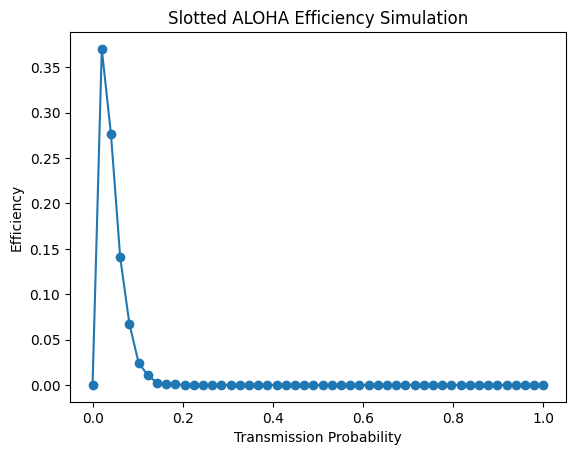

In [12]:

import random
import matplotlib.pyplot as plt
import numpy as np

def slotted_aloha(n_nodes, p, slots):
    # Count the number of slots with exactly one transmission.
    success = 0
    for _ in range(slots):
        transmissions = 0
        for _ in range(n_nodes):
            # Each node transmits with probability p in each slot.
            if random.random() < p:
                transmissions += 1
        # A successful transmission happens when exactly one node transmits.
        if transmissions == 1:
            success += 1
    # Efficiency is the fraction of slots with exactly one transmission.
    return success / slots

# Set simulation parameters
n_nodes = 50         # Number of nodes in the network
slots = 10000        # Number of time slots to simulate
ps = np.linspace(0, 1, 50)  # Different transmission probabilities

# Compute efficiency for each probability
efficiencies = [slotted_aloha(n_nodes, p, slots) for p in ps]

# Plot the result
plt.plot(ps, efficiencies, marker='o')
plt.xlabel('Transmission Probability')
plt.ylabel('Efficiency')
plt.title('Slotted ALOHA Efficiency Simulation')
plt.show()


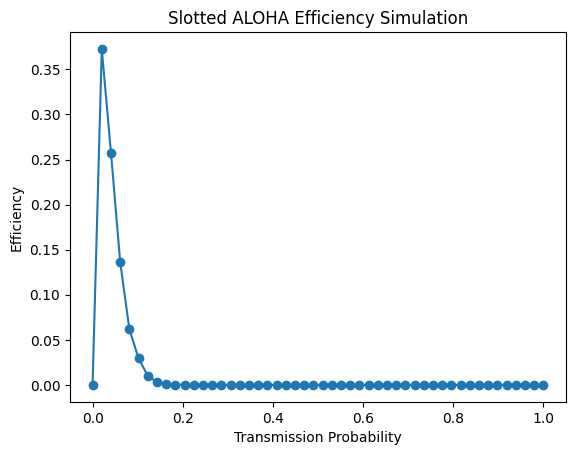

In [15]:
import random
import matplotlib.pyplot as plt
import numpy as np

def slotted_aloha(n_nodes, p, slots):
    # Count the number of slots with exactly one transmission.
    success = 0
    for _ in range(slots):
        transmissions = 0
        for _ in range(n_nodes):
            # Each node transmits with probability p in each slot.
            if random.random() < p:
                transmissions += 1
        # A successful transmission happens when exactly one node transmits.
        if transmissions == 1:
            success += 1
    # Efficiency is the fraction of slots with exactly one transmission.
    return success / slots

# Set simulation parameters
n_nodes = 50         # Number of nodes in the network
slots = 10000        # Number of time slots to simulate
ps = np.linspace(0, 1, 50)  # Different transmission probabilities

# Compute efficiency for each probability
efficiencies = [slotted_aloha(n_nodes, p, slots) for p in ps]

# Plot the result
plt.plot(ps, efficiencies, marker='o')
plt.xlabel('Transmission Probability')
plt.ylabel('Efficiency')
plt.title('Slotted ALOHA Efficiency Simulation')
plt.show()

